# COMP90051 Project 2
**Name:** *enter your name here*

**Student ID:** *your id here*

In [1]:
# You can add additional imports here
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import random

## 0. Loading the dataset

In [2]:
# do not edit this cell
# load the data files (download from the LMS)
embedded_images = np.load('images.npy')
labels = np.load('labels.npy')

# split into pool & testing
X_pool, X_test, y_pool, y_test = train_test_split(embedded_images, labels, 
                                                  test_size=0.5, random_state=1234, shuffle=True)

# sample a seed set
np.random.seed(1234)
label2id = defaultdict(list)
for i, label in enumerate(y_pool):
    label2id[label].append(i)
seed_set = []
for label, ids in label2id.items():
    seed_set.extend(np.random.choice(ids, size=10, replace=False))

In [3]:
seed_pool = X_pool[seed_set]
seed_pool_label = y_pool[seed_set]

In [4]:
unlabelled_set = [x for x in list(range(0,len(X_pool))) if x not in seed_set]

unlabelled_pool = X_pool[unlabelled_set]
unlabelled_label = y_pool[unlabelled_set]

In [5]:
unique, counts = np.unique(y_pool, return_counts=True)

print(np.asarray((unique, counts)).T)

[['Alphabet_of_the_Magi' '200']
 ['Anglo-Saxon_Futhorc' '302']
 ['Arcadian' '234']
 ['Armenian' '416']
 ['Asomtavruli_(Georgian)' '390']
 ['Balinese' '252']
 ['Bengali' '452']
 ['Blackfoot_(Canadian_Aboriginal_Syllabics)' '136']
 ['Braille' '263']
 ['Burmese_(Myanmar)' '338']
 ['Cyrillic' '331']
 ['Early_Aramaic' '226']
 ['Futurama' '265']
 ['Grantha' '454']
 ['Greek' '237']
 ['Gujarati' '473']
 ['Hebrew' '221']
 ['Inuktitut_(Canadian_Aboriginal_Syllabics)' '145']
 ['Japanese_(hiragana)' '507']
 ['Japanese_(katakana)' '480']
 ['Korean' '404']
 ['Latin' '292']
 ['Malay_(Jawi_-_Arabic)' '404']
 ['Mkhedruli_(Georgian)' '409']
 ['N_Ko' '331']
 ['Ojibwe_(Canadian_Aboriginal_Syllabics)' '128']
 ['Sanskrit' '410']
 ['Syriac_(Estrangelo)' '229']
 ['Tagalog' '162']
 ['Tifinagh' '549']]


## 1. Applying logistic regression

In [6]:
def train_logistic_regression(X, y, **args):
    """
    Train a logistic regression model on dataset (X, y) and return trained model.
    X: matrix of real values, size n x d
    y: vector of string labels, size n
    args: optional arguments e.g., for hyper-parameters
    """
    model = LogisticRegression(**args).fit(X,y)
    return model

In [7]:
def evaluate_logistic_regression_accuracy(Xt, yt, model):
    """
    Apply logistic regression prediction on dataset Xt and evaluate accuracy against yt,
    returing the accuracy results as a scalar.
    Xt: matrix of real values, size m x d
    yt: vector of string labels, size m
    """
    score = model.score(Xt,yt)

    return score

In [8]:
# Train Models
full_pool_LR= train_logistic_regression(X_pool,y_pool, max_iter = 10000)
seet_pool_LR= train_logistic_regression(seed_pool,seed_pool_label, max_iter = 10000)

In [9]:
full_pool_train_acc = evaluate_logistic_regression_accuracy(X_pool,y_pool,full_pool_LR)
full_pool_test_acc = evaluate_logistic_regression_accuracy(X_test,y_test,full_pool_LR)

print("Train Accuracy for full pool: ",full_pool_train_acc)
print("Test Accuracy for full pool: ",full_pool_test_acc)

Train Accuracy for full pool:  0.904356846473029
Test Accuracy for full pool:  0.5835062240663901


In [12]:
seed_pool_train_acc = evaluate_logistic_regression_accuracy(seed_pool,seed_pool_label,seet_pool_LR)
seed_pool_test_acc = evaluate_logistic_regression_accuracy(X_test,y_test,seet_pool_LR)

print("Train Accuracy for seed pool: ",seed_pool_train_acc)
print("Test Accuracy for seed pool: ",seed_pool_test_acc)

Train Accuracy for seed pool:  1.0
Test Accuracy for seed pool:  0.3146265560165975


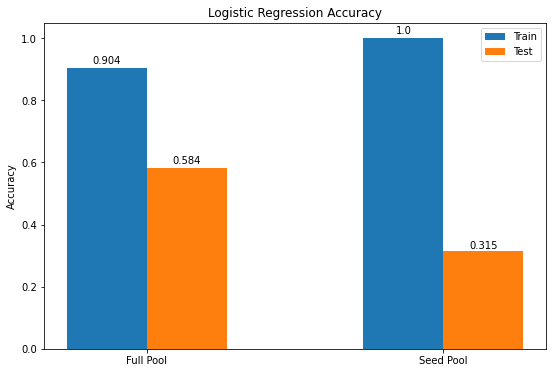

In [13]:
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111)

train_vals = [full_pool_train_acc,seed_pool_train_acc]
rects1 = ax.bar(ind, train_vals, width)
test_vals = [full_pool_test_acc,seed_pool_test_acc]
rects2 = ax.bar(ind+width, test_vals, width)

ax.set_ylabel('Accuracy')
ax.set_xticks(ind+width/2)
ax.set_xticklabels( ('Full Pool', 'Seed Pool') )
ax.legend( (rects1[0], rects2[0]), ('Train', 'Test'),loc = 1 )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, round(h,3),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.title("Logistic Regression Accuracy")


plt.show()

## 2. Active learning framework with Random selection

In [18]:
def random_select(X, model):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a model (not used)
    returns a vector of scores of length n. Each entry reflects the priority 
    of the corresponding instance. Higher means better.
    """

    #score = model.predict_proba(X)
    #score = np.amax(result, axis=1)
    
    # score_list = []
    # for index in range(len(index_set)):
    #     score_list.append([score[index],index_set[index]])    

    # score_list = sorted(score_list)

    score = [random.uniform(0, 1) for i in range(len(X))]

    return score

In [25]:
def pool_based_active_learning(X_pool, y_pool, seed_ids,
                               train_func, select_func,
                               max_size, batch_size, **args):
    """
    Perform an active learning simulation, which starts by training on a seed set,
    then iteratively applies the selection function to rank instances in the pool,
    selects the top few instances which are included into the training set and the
    process repeats. 
        X_pool: matrix of n x d
        y_pool: vector of string labels, size n
        seed_ids: initial labelled set set, as a list of indices [0..n-1] into pool
        train_func: function which given (X, y, optional args) returns a trained model
        select_func: function which given (X, optional args) returns a sequence of scores
        max_size: stopping condition for active learning, when labelled data reaches given size
        batch_size: number of instances to be labelled in each iteration
        args: optional arguments passed to training and selection function
    returns the sequence of trained models 
    """

    while len(X_pool) <= max_size:
        print("lala")
        model = train_logistic_regression(X_pool,y_pool,**args)
        score = random_select(X_pool,model)
        r = sorted(range(len(score)), key=lambda k: score[k])[:batch_size]

        print(r)
        break


    # fill in

In [23]:
batch = 60
max_size = 3000
models_random = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_logistic_regression, random_select, 
                                    max_size, batch)

In [26]:
pool_based_active_learning(X_pool, y_pool, seed_set, 
                                    train_logistic_regression, random_select, 
                                    max_size, batch)

lala


In [ ]:
## your code here for evaluation of accuracy and plotting of results

In [183]:
 = random_select(unlabelled_pool,seet_pool_LR)
r = sorted(range(len(score)), key=lambda k: score[k])

In [186]:
y_pool[r]

array(['Early_Aramaic', 'Braille', 'Futurama', ..., 'Bengali',
       'Blackfoot_(Canadian_Aboriginal_Syllabics)',
       'Inuktitut_(Canadian_Aboriginal_Syllabics)'], dtype='<U41')

In [169]:
random_select(seed_pool, seet_pool_LR)


[0.21314927456950716,
 0.30640583871585025,
 0.9287116929936873,
 0.7457951618789109,
 0.9763717338139811,
 0.9914591728068555,
 0.43978118577905534,
 0.36501902616468185,
 0.005482874112722302,
 0.27931738156441477,
 0.699554266357252,
 0.017709628803846744,
 0.025067300151153216,
 0.5661317180854885,
 0.7291547051244205,
 0.2615681604245145,
 0.14554950125098798,
 0.8167704998396103,
 0.18536471906998098,
 0.15699066925630045,
 0.4981455477441191,
 0.617062048724146,
 0.6242277613645614,
 0.8699565249386196,
 0.40434124496789414,
 0.41230326646813964,
 0.7883016999450153,
 0.45025405844265065,
 0.46850473350210664,
 0.7995389196337707,
 0.004313236755276062,
 0.14620099656046126,
 0.5388158106654507,
 0.7941643473997365,
 0.6982769083247605,
 0.030655064117281472,
 0.44250938857852395,
 0.0534742979902636,
 0.796283903924101,
 0.4277495947150206,
 0.5340291253183601,
 0.9347756967428138,
 0.8287737491914574,
 0.23490187687520014,
 0.43351383623516726,
 0.3157531986624934,
 0.44094896

## 3. Uncertainty sampling

In [ ]:
def logistic_regression_entropy_select(X, model, **args):
    """
    Given an unlabelled dataset X, a matrix of n x d, and a discriminative model 
    P(y|x), returns a vector of n entropy values.
    """
    # fill in
    pass

In [ ]:
models_us = pool_based_active_learning(X_pool, y_pool, seed_set, 
                                 train_logistic_regression, 
                                 logistic_regression_entropy_select, 
                                 max_size, batch)

In [ ]:
## your code here for evaluation of accuracy and plotting of results

## 4. Query by committee

In [ ]:
# don't forget to provide function descriptive comments, like those provided in templates above

def query_by_committee_vote_entropy(X, model, **args):
    pass

def query_by_committee_soft_vote_entropy(X, model, **args):
    pass

def query_by_committee_KL(X, model, **args):
    pass

In [ ]:
def train_committee(X, y, **args):
    pass

In [ ]:
## your code here for training, evaluation, and plotting code

## 5. Hierarchical sampling

In [1]:
## your code